<h1 id="Kaggle-Digit-Recognizer ">Kaggle Digit Recognizer&nbsp;</h1>

<h2 id="MNIST-Image-Classification with-Keras-CNN-model">MNIST Image Classification&nbsp;with Keras CNN model</h2>

<p>procedure:</p>

<ol>
	<li>Image input from local data, normalized and reshape input to [-1, HEIGHT, WIDTH, 1]</li>
	<li>data&nbsp;augmentation</li>
	<li>CNN model, ir = 0.001 with decrease schedule</li>
	<li>train for 20 &nbsp;- 30 epochs</li>
</ol>

<p>&nbsp;</p>

<p>&nbsp;</p>


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import pydot
import os

from sklearn.model_selection import train_test_split


import tensorflow as tf
print(tf.__version__)

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

1.13.1


<h2 id="Exploring-and-processing data">Exploring and processing&nbsp;data</h2>


In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

In [4]:
sample_submission.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [5]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
train.label.count()

42000

In [7]:
train_images = train.drop(labels = ["label"],axis = 1)
train_labels = train["label"]


In [8]:
train_images = train_images.to_numpy()/255.0
test_images = test.to_numpy()/255.0


In [9]:
HEIGHT = 28
WIDTH = 28
NCLASSES = 10

In [10]:
train_images = train_images.reshape(-1,HEIGHT,WIDTH,1)
test_images = test_images.reshape(-1,HEIGHT,WIDTH,1)

train_labels = keras.utils.to_categorical(train_labels, num_classes = NCLASSES)

In [11]:
train_labels[:5]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

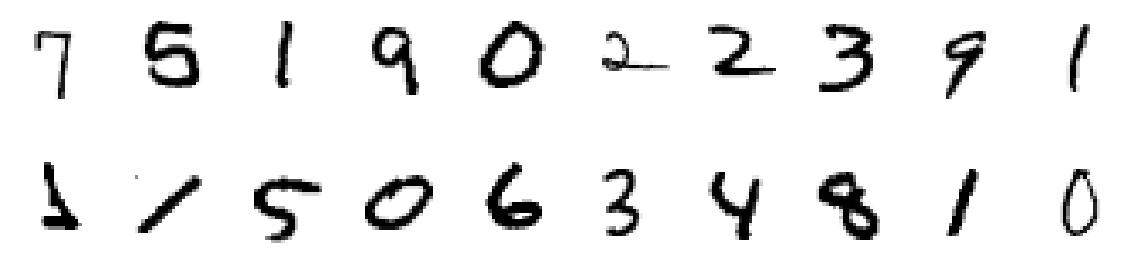

In [12]:
i = 50
plt.figure(figsize=(20,5))
for IMGNO in range(i,i+20):  
    plt.subplot(2, 10, IMGNO-i+1)
    plt.imshow(train_images[IMGNO].reshape(HEIGHT, WIDTH), cmap=plt.cm.binary)
    plt.axis('off')

In [41]:
X_train, X_val, Y_train, Y_val = train_test_split(train_images, train_labels, test_size = 0.1)

len(Y_train)

37800

### Data augmentation

In [45]:
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

datagen.fit(X_train)

## CNN model with Keras functional API


In [103]:
X = keras.layers.Input(shape = (HEIGHT, WIDTH, 1))

c1 = keras.layers.Conv2D(filters = 16, kernel_size = 5, strides = 1, padding = 'same', activation = 'relu')(X)   # shape = (batch_size, HEIGHT, WIDTH, nfil1)

#c1 = keras.layers.BatchNormalization()(c1)          
                      
p1 = keras.layers.MaxPool2D(pool_size = 2, strides = 2)(c1)                                                       # shape = (batch_size, HEIGHT // 2, WIDTH // 2, nfil1)
    
c2 = keras.layers.Conv2D(filters = 32, kernel_size = 5, strides = 1, padding = 'same', activation = 'relu')(p1)    # shape = (batch_size, HEIGHT // 2, WIDTH // 2, nfil2)
    
#c2 = keras.layers.BatchNormalization()(c2)   

p2 = keras.layers.MaxPool2D(pool_size = 2, strides = 2)(c2)                                                        # shape = (batch_size, HEIGHT // 4, WIDTH // 4, nfil2)

c3 = keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(p2)    # shape = (batch_size, HEIGHT // 2, WIDTH // 2, nfil2)

#c3 = keras.layers.BatchNormalization()(c3)      

p3 = keras.layers.MaxPool2D(pool_size = 2, strides = 2)(c3)                                                      # shape = (batch_size, HEIGHT // 4, WIDTH // 4, nfil2)

p3 = keras.layers.Flatten()(p3)                                                                               # shape = (batch_size, HEIGHT // 4 * WIDTH // 4 * nfil2)

h3 = keras.layers.Dense(units = 64, activation = 'relu')(p3)
    
#h3 = keras.layers.BatchNormalization()(h3)               
    
h3 = keras.layers.Dropout(rate = 0.25)(h3)

output = keras.layers.Dense(units = NCLASSES, activation = 'softmax')(h3)
  
#output = keras.layers.BatchNormalization()(output)



In [104]:
model = keras.Model(inputs=X, outputs=output)

print(model.summary())

#keras.utils.plot_model(model, to_file='digit-cnn-keras_graph.png')

#display(Image.open('digit-cnn-keras_graph.png'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 14, 32)        12832     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 3, 3, 64)          0         
__________

In [105]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

<h3>train model</h3>


In [96]:
# no augmentation
#_= model.fit(X_train, Y_train, 
#            batch_size = 100,
#            epochs=20,
#            verbose=1, 
#            validation_data = (X_val, Y_val) 
#            )
    

Train on 37800 samples, validate on 4200 samples
Epoch 1/20
37800/37800 [==============================] - 57s 1ms/sample - loss: 0.3892 - acc: 0.8795 - val_loss: 0.0731 - val_acc: 0.9760
Epoch 2/20
37800/37800 [==============================] - 57s 2ms/sample - loss: 0.0965 - acc: 0.9713 - val_loss: 0.0581 - val_acc: 0.9810
Epoch 3/20
37800/37800 [==============================] - 57s 1ms/sample - loss: 0.0735 - acc: 0.9778 - val_loss: 0.0508 - val_acc: 0.9840
Epoch 4/20
37800/37800 [==============================] - 58s 2ms/sample - loss: 0.0540 - acc: 0.9844 - val_loss: 0.0411 - val_acc: 0.9874
Epoch 5/20
37800/37800 [==============================] - 57s 2ms/sample - loss: 0.0442 - acc: 0.9873 - val_loss: 0.0415 - val_acc: 0.9864
Epoch 6/20
37800/37800 [==============================] - 58s 2ms/sample - loss: 0.0402 - acc: 0.9876 - val_loss: 0.0384 - val_acc: 0.9879
Epoch 7/20
37800/37800 [==============================] - 58s 2ms/sample - loss: 0.0326 - acc: 0.9895 - val_loss: 0.0

In [106]:
# with augmentation
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
batch_size = 100
epochs = 30
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, 
                              validation_data = (X_val,Y_val),
                              verbose = 1, 
                              steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks=[annealer])

Epoch 1/30
378/378 [==============================] - 62s 165ms/step - loss: 0.5602 - acc: 0.8174 - val_loss: 0.1026 - val_acc: 0.9686
Epoch 2/30
378/378 [==============================] - 63s 166ms/step - loss: 0.1839 - acc: 0.9454 - val_loss: 0.0687 - val_acc: 0.9790
Epoch 3/30
378/378 [==============================] - 62s 165ms/step - loss: 0.1368 - acc: 0.9590 - val_loss: 0.0569 - val_acc: 0.9838
Epoch 4/30
378/378 [==============================] - 67s 178ms/step - loss: 0.1095 - acc: 0.9671 - val_loss: 0.0516 - val_acc: 0.9848
Epoch 5/30
378/378 [==============================] - 60s 160ms/step - loss: 0.0911 - acc: 0.9735 - val_loss: 0.0417 - val_acc: 0.9874
Epoch 6/30
378/378 [==============================] - 59s 156ms/step - loss: 0.0792 - acc: 0.9769 - val_loss: 0.0523 - val_acc: 0.9840
Epoch 7/30
378/378 [==============================] - 60s 160ms/step - loss: 0.0748 - acc: 0.9776 - val_loss: 0.0339 - val_acc: 0.9893
Epoch 8/30
378/378 [==============================] - 6

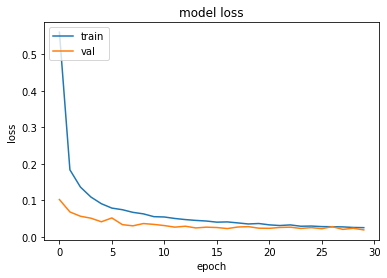

loss: 0.0195   


In [107]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

print("loss: {0:.4f}   ".format(history.history['val_loss'][-1]))

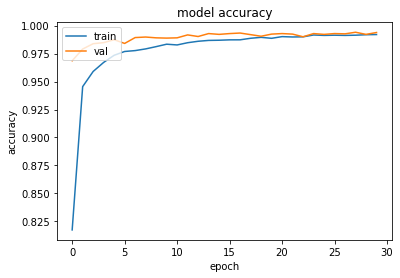

Acc: 0.9938  


In [108]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

print("Acc: {0:.4f}  ".format(history.history['val_acc'][-1],))

### Prediction

In [109]:
pred = model.predict(test_images, batch_size=2000, 
                       verbose=1)
pred = np.argmax(pred, axis=1)

28000/28000 [==============================] - 15s 547us/sample


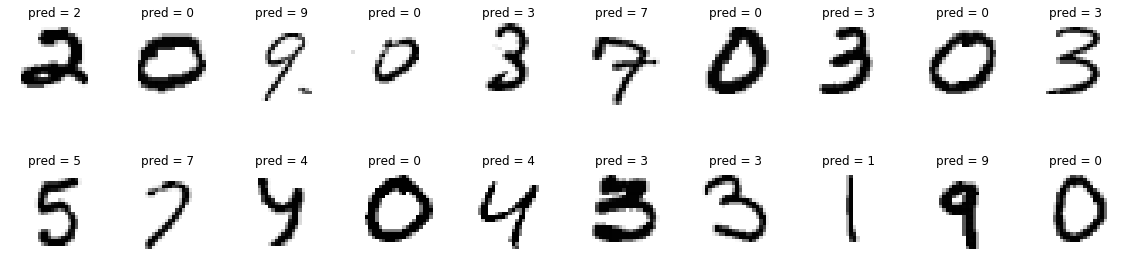

In [110]:
i=0
plt.figure(figsize=(20,5))
for IMGNO in range(i,i+20):  
    plt.subplot(2, 10, IMGNO-i+1)
    plt.imshow(test_images[IMGNO].reshape((28,28)),cmap=plt.cm.binary)
    plt.title("pred = %d" % pred[IMGNO],y=0.9)
    plt.axis('off')
#plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()

In [111]:
pred[:10]

array([2, 0, 9, 0, 3, 7, 0, 3, 0, 3], dtype=int64)

## Output

In [112]:
output = pd.DataFrame({ 'ImageId' : np.arange(len(pred))+1, 'Label': pred })
output.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [113]:
#output.to_csv('data/sub_digit_v01_cnn_keras_da_nbn_30ep.csv', index = False)


In [114]:
#model.save("data/sub_digit_v01_cnn_keras_da_nbn_30ep.h5")

<p>Score board</p>

<table border="2" cellpadding="1" cellspacing="1" style="width: 500px">
	<tbody>
		<tr>
			<td><strong>kaggle score</strong></td>
			<td><strong>rank</strong></td>
			<td><strong>data augmentation</strong></td>
			<td><strong>batch norm</strong></td>
			<td><strong>epochs</strong></td>
		</tr>
		<tr>
			<td>0.99057</td>
			<td>&nbsp;</td>
			<td>No</td>
			<td>No</td>
			<td>20</td>
		</tr>
		<tr>
			<td>0.99185</td>
			<td>1017</td>
			<td>No</td>
			<td>Yes</td>
			<td>20</td>
		</tr>
		<tr>
			<td>0.99257</td>
			<td>910</td>
			<td>Yes</td>
			<td>No</td>
			<td>20</td>
		</tr>
		<tr>
			<td>0.99457</td>
			<td>655</td>
			<td>Yes</td>
			<td>No</td>
			<td>30</td>
		</tr>
	</tbody>
</table>

<p>&nbsp;</p>


<h2 id="Credits">Next step to improve acc</h2>

<ul>
	<li>implement ensemble models</li>
	<li>add confusion matrix</li>
</ul>

<p>&nbsp;</p>

<h2>Credits</h2>

<p><a href="https://www.kaggle.com/cdeotte/25-million-images-0-99757-mnist" target="_blank">https://www.kaggle.com/cdeotte/25-million-images-0-99757-mnist</a></p>

<p><a href="https://www.kaggle.com/dingli/digits-recognition-with-cnn-keras" target="_blank">https://www.kaggle.com/dingli/digits-recognition-with-cnn-keras</a></p>
